## Visualize Track results

In [1]:
from pathlib import Path
import cv2
import sys
import numpy as np
from skimage import feature, measure
import livecell_tracker
from livecell_tracker.segment import datasets
import livecell_tracker.segment
from livecell_tracker import segment
import livecell_tracker.core.utils
from tqdm import tqdm

seg_path = r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\segmentation_results\detectron_model3\restart_day0_Group 1_wellA1_RI_MIP_stitched"""
label_seg_imgs = segment.datasets.LiveCellImageDataset(seg_path, ext="png")
dir_path = Path(
    r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
)
raw_imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="png")


288 png img file paths loaded: 
288 png img file paths loaded: 


### load bbox paths

In [2]:
import json
_track_bbs_path = r"..\cxa-data\test_data\sort_track\max_age-5_min_live-2_detectron_model3_all_track_bbs-restart_day0_Group 1_wellA1_RI_MIP_stitched.json"
with open(_track_bbs_path, "r") as in_f:
    json_in = json.load(in_f)
type(json_in[0][0][0])

int

In [3]:
all_track_bbs = [np.array(track_bbs, dtype=int) for track_bbs in json_in]


In [4]:
all_track_bbs[0].shape


(27, 5)

### Manually check bboxes  
 - be careful: coordinates of numpy/skimage/cv2/pixel/rowCol/bbox

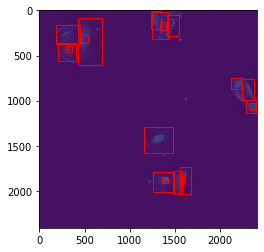

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

idx = 2
bboxes = all_track_bbs[idx]
fig, ax = plt.subplots()
ax.imshow(raw_imgs[idx])
for bbox in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (bbox[1], bbox[0]),
        (bbox[3] - bbox[1]),
        (bbox[2] - bbox[0]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
# plt.show()


Add information to SingleCellTrajectory

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic, single_cell

id_to_sc_trajs = {}
for timeframe, objects in enumerate(all_track_bbs):
    for obj in objects:
        track_id = obj[-1]
        if not (track_id in id_to_sc_trajs):
            new_traj = SingleCellTrajectory(raw_imgs, track_id=track_id)
            id_to_sc_trajs[track_id] = new_traj
        # print("obj: ", obj)
        sc = SingleCellStatic(
            timeframe, bbox=obj[:4], img_dataset=raw_imgs
        )  # final column is track_id, ignore as we only need bbox here
        _traj = id_to_sc_trajs[track_id]
        _traj.add_timeframe_data(timeframe, sc)


In [7]:
%matplotlib widget
from typing import List
from livecell_tracker.track.movie import generate_single_trajectory_movie
output_path = Path("./track_tmp")
output_path.mkdir(exist_ok=True)
for traj_id, traj in id_to_sc_trajs.items():
    generate_single_trajectory_movie(
        traj, raw_imgs, save_path=output_path / "track_{}.gif".format(traj_id)
    )
    plt.close("all")


[Viz] skipping the current trajectory track_id:  27
[Viz] skipping the current trajectory track_id:  26
[Viz] skipping the current trajectory track_id:  25
[Viz] skipping the current trajectory track_id:  24
[Viz] skipping the current trajectory track_id:  23
[Viz] skipping the current trajectory track_id:  22
[Viz] skipping the current trajectory track_id:  21
[Viz] skipping the current trajectory track_id:  20
[Viz] skipping the current trajectory track_id:  19
[Viz] skipping the current trajectory track_id:  18


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_17.gif...
[Viz] skipping the current trajectory track_id:  16


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_15.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_14.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_13.gif...
[Viz] skipping the current trajectory track_id:  12


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_11.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_10.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_9.gif...
[Viz] skipping the current trajectory track_id:  8
[Viz] skipping the current trajectory track_id:  7


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_6.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_5.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_4.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_3.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_2.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_1.gif...
[Viz] skipping the current trajectory track_id:  32


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_29.gif...
[Viz] skipping the current trajectory track_id:  28
[Viz] skipping the current trajectory track_id:  34
[Viz] skipping the current trajectory track_id:  33
[Viz] skipping the current trajectory track_id:  37


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_36.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_35.gif...
[Viz] skipping the current trajectory track_id:  45
[Viz] skipping the current trajectory track_id:  44
[Viz] skipping the current trajectory track_id:  42
[Viz] skipping the current trajectory track_id:  40
[Viz] skipping the current trajectory track_id:  47
[Viz] skipping the current trajectory track_id:  46
[Viz] skipping the current trajectory track_id:  43
[Viz] skipping the current trajectory track_id:  51
[Viz] skipping the current trajectory track_id:  48


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_56.gif...
[Viz] skipping the current trajectory track_id:  55


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_53.gif...
[Viz] skipping the current trajectory track_id:  59
[Viz] skipping the current trajectory track_id:  58
[Viz] skipping the current trajectory track_id:  54
[Viz] skipping the current trajectory track_id:  63
[Viz] skipping the current trajectory track_id:  62
[Viz] skipping the current trajectory track_id:  60
saving to: track_tmp\track_65.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


[Viz] skipping the current trajectory track_id:  66
[Viz] skipping the current trajectory track_id:  72
[Viz] skipping the current trajectory track_id:  75


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_76.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)


[Viz] skipping the current trajectory track_id:  74


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_79.gif...
[Viz] skipping the current trajectory track_id:  78
[Viz] skipping the current trajectory track_id:  80
[Viz] skipping the current trajectory track_id:  84
[Viz] skipping the current trajectory track_id:  83
[Viz] skipping the current trajectory track_id:  89
[Viz] skipping the current trajectory track_id:  88


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_87.gif...
[Viz] skipping the current trajectory track_id:  95
[Viz] skipping the current trajectory track_id:  94
[Viz] skipping the current trajectory track_id:  93
[Viz] skipping the current trajectory track_id:  91
[Viz] skipping the current trajectory track_id:  90
[Viz] skipping the current trajectory track_id:  98


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_103.gif...
[Viz] skipping the current trajectory track_id:  102
[Viz] skipping the current trajectory track_id:  101
[Viz] skipping the current trajectory track_id:  111


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_109.gif...
[Viz] skipping the current trajectory track_id:  108
[Viz] skipping the current trajectory track_id:  105
[Viz] skipping the current trajectory track_id:  113


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_104.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_118.gif...
[Viz] skipping the current trajectory track_id:  117
[Viz] skipping the current trajectory track_id:  115
[Viz] skipping the current trajectory track_id:  112
[Viz] skipping the current trajectory track_id:  122
[Viz] skipping the current trajectory track_id:  119
[Viz] skipping the current trajectory track_id:  116
[Viz] skipping the current trajectory track_id:  123
[Viz] skipping the current trajectory track_id:  126
[Viz] skipping the current trajectory track_id:  132
[Viz] skipping the current trajectory track_id:  130
[Viz] skipping the current trajectory track_id:  136


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_135.gif...
[Viz] skipping the current trajectory track_id:  134


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_139.gif...
[Viz] skipping the current trajectory track_id:  138
[Viz] skipping the current trajectory track_id:  137
[Viz] skipping the current trajectory track_id:  149
[Viz] skipping the current trajectory track_id:  148
[Viz] skipping the current trajectory track_id:  146
[Viz] skipping the current trajectory track_id:  142
[Viz] skipping the current trajectory track_id:  141


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_154.gif...
[Viz] skipping the current trajectory track_id:  153
[Viz] skipping the current trajectory track_id:  143


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_158.gif...
[Viz] skipping the current trajectory track_id:  156
[Viz] skipping the current trajectory track_id:  159
[Viz] skipping the current trajectory track_id:  169
[Viz] skipping the current trajectory track_id:  164
[Viz] skipping the current trajectory track_id:  174
[Viz] skipping the current trajectory track_id:  173
[Viz] skipping the current trajectory track_id:  172


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_165.gif...
[Viz] skipping the current trajectory track_id:  181
[Viz] skipping the current trajectory track_id:  179
[Viz] skipping the current trajectory track_id:  178
[Viz] skipping the current trajectory track_id:  177
[Viz] skipping the current trajectory track_id:  183
[Viz] skipping the current trajectory track_id:  186
[Viz] skipping the current trajectory track_id:  185
[Viz] skipping the current trajectory track_id:  194


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_192.gif...
[Viz] skipping the current trajectory track_id:  191


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_190.gif...
[Viz] skipping the current trajectory track_id:  199
[Viz] skipping the current trajectory track_id:  198
[Viz] skipping the current trajectory track_id:  197
[Viz] skipping the current trajectory track_id:  196


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_200.gif...
[Viz] skipping the current trajectory track_id:  206
[Viz] skipping the current trajectory track_id:  207
[Viz] skipping the current trajectory track_id:  204
[Viz] skipping the current trajectory track_id:  211
[Viz] skipping the current trajectory track_id:  210
[Viz] skipping the current trajectory track_id:  218
[Viz] skipping the current trajectory track_id:  221
[Viz] skipping the current trajectory track_id:  220
[Viz] skipping the current trajectory track_id:  227


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_224.gif...
[Viz] skipping the current trajectory track_id:  223


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_231.gif...
[Viz] skipping the current trajectory track_id:  229
[Viz] skipping the current trajectory track_id:  237


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_236.gif...
[Viz] skipping the current trajectory track_id:  234
[Viz] skipping the current trajectory track_id:  233


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_230.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_246.gif...
[Viz] skipping the current trajectory track_id:  250
[Viz] skipping the current trajectory track_id:  254
[Viz] skipping the current trajectory track_id:  253
[Viz] skipping the current trajectory track_id:  252
[Viz] skipping the current trajectory track_id:  258
[Viz] skipping the current trajectory track_id:  263
[Viz] skipping the current trajectory track_id:  259
[Viz] skipping the current trajectory track_id:  267
[Viz] skipping the current trajectory track_id:  261
[Viz] skipping the current trajectory track_id:  269


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_264.gif...
[Viz] skipping the current trajectory track_id:  276
[Viz] skipping the current trajectory track_id:  274
[Viz] skipping the current trajectory track_id:  271


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_284.gif...
[Viz] skipping the current trajectory track_id:  281


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_279.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_278.gif...
[Viz] skipping the current trajectory track_id:  292


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_289.gif...
[Viz] skipping the current trajectory track_id:  288
[Viz] skipping the current trajectory track_id:  293
[Viz] skipping the current trajectory track_id:  291


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_299.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_298.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_295.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_304.gif...
[Viz] skipping the current trajectory track_id:  301
[Viz] skipping the current trajectory track_id:  306
[Viz] skipping the current trajectory track_id:  305
[Viz] skipping the current trajectory track_id:  303
[Viz] skipping the current trajectory track_id:  313


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_311.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_310.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_317.gif...
[Viz] skipping the current trajectory track_id:  314
[Viz] skipping the current trajectory track_id:  321
[Viz] skipping the current trajectory track_id:  319
[Viz] skipping the current trajectory track_id:  316
[Viz] skipping the current trajectory track_id:  322


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_320.gif...
[Viz] skipping the current trajectory track_id:  327


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_326.gif...
[Viz] skipping the current trajectory track_id:  332
[Viz] skipping the current trajectory track_id:  330
[Viz] skipping the current trajectory track_id:  328
[Viz] skipping the current trajectory track_id:  335
[Viz] skipping the current trajectory track_id:  340
[Viz] skipping the current trajectory track_id:  346
[Viz] skipping the current trajectory track_id:  345
[Viz] skipping the current trajectory track_id:  344
[Viz] skipping the current trajectory track_id:  349
[Viz] skipping the current trajectory track_id:  353
[Viz] skipping the current trajectory track_id:  352


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_357.gif...
[Viz] skipping the current trajectory track_id:  356
[Viz] skipping the current trajectory track_id:  358
[Viz] skipping the current trajectory track_id:  355
[Viz] skipping the current trajectory track_id:  360
[Viz] skipping the current trajectory track_id:  363
[Viz] skipping the current trajectory track_id:  362
[Viz] skipping the current trajectory track_id:  366
[Viz] skipping the current trajectory track_id:  369
[Viz] skipping the current trajectory track_id:  365
[Viz] skipping the current trajectory track_id:  373


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_376.gif...
[Viz] skipping the current trajectory track_id:  375
[Viz] skipping the current trajectory track_id:  378
[Viz] skipping the current trajectory track_id:  382
[Viz] skipping the current trajectory track_id:  381
[Viz] skipping the current trajectory track_id:  380
[Viz] skipping the current trajectory track_id:  388
[Viz] skipping the current trajectory track_id:  387
[Viz] skipping the current trajectory track_id:  386


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_385.gif...
[Viz] skipping the current trajectory track_id:  384
[Viz] skipping the current trajectory track_id:  394
[Viz] skipping the current trajectory track_id:  393
[Viz] skipping the current trajectory track_id:  405
[Viz] skipping the current trajectory track_id:  402
[Viz] skipping the current trajectory track_id:  396
[Viz] skipping the current trajectory track_id:  408


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_411.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_414.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_421.gif...
[Viz] skipping the current trajectory track_id:  419
[Viz] skipping the current trajectory track_id:  418
[Viz] skipping the current trajectory track_id:  417
[Viz] skipping the current trajectory track_id:  413
[Viz] skipping the current trajectory track_id:  420
[Viz] skipping the current trajectory track_id:  416


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_415.gif...
[Viz] skipping the current trajectory track_id:  423
[Viz] skipping the current trajectory track_id:  426
[Viz] skipping the current trajectory track_id:  429
[Viz] skipping the current trajectory track_id:  428
[Viz] skipping the current trajectory track_id:  431
[Viz] skipping the current trajectory track_id:  433
[Viz] skipping the current trajectory track_id:  439
[Viz] skipping the current trajectory track_id:  438
[Viz] skipping the current trajectory track_id:  437
[Viz] skipping the current trajectory track_id:  446
[Viz] skipping the current trajectory track_id:  444
[Viz] skipping the current trajectory track_id:  442
[Viz] skipping the current trajectory track_id:  450
[Viz] skipping the current trajectory track_id:  449
[Viz] skipping the current trajectory track_id:  448
[Viz] skipping the current trajectory track_id:  456
[Viz] skipping the current trajectory track_id:  455
[Viz] skipping the current trajectory track_id:  454
[Viz] sk

MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_462.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_461.gif...
[Viz] skipping the current trajectory track_id:  468
[Viz] skipping the current trajectory track_id:  465
[Viz] skipping the current trajectory track_id:  466
[Viz] skipping the current trajectory track_id:  471
[Viz] skipping the current trajectory track_id:  474
[Viz] skipping the current trajectory track_id:  480


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_479.gif...
[Viz] skipping the current trajectory track_id:  484


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_482.gif...
[Viz] skipping the current trajectory track_id:  481
[Viz] skipping the current trajectory track_id:  486


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_487.gif...
[Viz] skipping the current trajectory track_id:  493
[Viz] skipping the current trajectory track_id:  491
[Viz] skipping the current trajectory track_id:  489
[Viz] skipping the current trajectory track_id:  495
[Viz] skipping the current trajectory track_id:  494


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_496.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_500.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_503.gif...
[Viz] skipping the current trajectory track_id:  499
[Viz] skipping the current trajectory track_id:  504
[Viz] skipping the current trajectory track_id:  507


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_506.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_510.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_512.gif...
[Viz] skipping the current trajectory track_id:  517
[Viz] skipping the current trajectory track_id:  520
[Viz] skipping the current trajectory track_id:  518
[Viz] skipping the current trajectory track_id:  516
[Viz] skipping the current trajectory track_id:  523


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_522.gif...
[Viz] skipping the current trajectory track_id:  526


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_527.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)
MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_532.gif...
[Viz] skipping the current trajectory track_id:  531


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_533.gif...
[Viz] skipping the current trajectory track_id:  535


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_539.gif...
[Viz] skipping the current trajectory track_id:  538
[Viz] skipping the current trajectory track_id:  536


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_545.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_543.gif...
[Viz] skipping the current trajectory track_id:  544
[Viz] skipping the current trajectory track_id:  548
[Viz] skipping the current trajectory track_id:  552


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_551.gif...
[Viz] skipping the current trajectory track_id:  550
[Viz] skipping the current trajectory track_id:  554


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_557.gif...
[Viz] skipping the current trajectory track_id:  561
[Viz] skipping the current trajectory track_id:  564
[Viz] skipping the current trajectory track_id:  563
[Viz] skipping the current trajectory track_id:  562


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_565.gif...
[Viz] skipping the current trajectory track_id:  573


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_570.gif...
[Viz] skipping the current trajectory track_id:  569
[Viz] skipping the current trajectory track_id:  576
[Viz] skipping the current trajectory track_id:  581


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_579.gif...
[Viz] skipping the current trajectory track_id:  578
[Viz] skipping the current trajectory track_id:  580
[Viz] skipping the current trajectory track_id:  588
[Viz] skipping the current trajectory track_id:  589
[Viz] skipping the current trajectory track_id:  592


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_595.gif...
[Viz] skipping the current trajectory track_id:  597
[Viz] skipping the current trajectory track_id:  599
[Viz] skipping the current trajectory track_id:  603
[Viz] skipping the current trajectory track_id:  601


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_600.gif...
[Viz] skipping the current trajectory track_id:  602
[Viz] skipping the current trajectory track_id:  607
[Viz] skipping the current trajectory track_id:  606
[Viz] skipping the current trajectory track_id:  609
[Viz] skipping the current trajectory track_id:  608
[Viz] skipping the current trajectory track_id:  611
[Viz] skipping the current trajectory track_id:  618


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_619.gif...
[Viz] skipping the current trajectory track_id:  620
[Viz] skipping the current trajectory track_id:  622
[Viz] skipping the current trajectory track_id:  626
[Viz] skipping the current trajectory track_id:  629
[Viz] skipping the current trajectory track_id:  628
[Viz] skipping the current trajectory track_id:  634
[Viz] skipping the current trajectory track_id:  639
[Viz] skipping the current trajectory track_id:  638
[Viz] skipping the current trajectory track_id:  641


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_640.gif...
[Viz] skipping the current trajectory track_id:  645
[Viz] skipping the current trajectory track_id:  643
[Viz] skipping the current trajectory track_id:  647
[Viz] skipping the current trajectory track_id:  652
[Viz] skipping the current trajectory track_id:  654
[Viz] skipping the current trajectory track_id:  657
[Viz] skipping the current trajectory track_id:  656
[Viz] skipping the current trajectory track_id:  661
[Viz] skipping the current trajectory track_id:  660
[Viz] skipping the current trajectory track_id:  666
[Viz] skipping the current trajectory track_id:  669
[Viz] skipping the current trajectory track_id:  668
[Viz] skipping the current trajectory track_id:  664
[Viz] skipping the current trajectory track_id:  672


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_675.gif...
[Viz] skipping the current trajectory track_id:  681
[Viz] skipping the current trajectory track_id:  680
[Viz] skipping the current trajectory track_id:  685


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_684.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_682.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_688.gif...
[Viz] skipping the current trajectory track_id:  686
[Viz] skipping the current trajectory track_id:  700


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_697.gif...
[Viz] skipping the current trajectory track_id:  691
[Viz] skipping the current trajectory track_id:  701
[Viz] skipping the current trajectory track_id:  698
[Viz] skipping the current trajectory track_id:  702
saving to: track_tmp\track_705.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


[Viz] skipping the current trajectory track_id:  703
[Viz] skipping the current trajectory track_id:  706


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_710.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)


[Viz] skipping the current trajectory track_id:  709


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_716.gif...


d:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\livecell_tracker\core\single_cell.py:98: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(img_crop)


[Viz] skipping the current trajectory track_id:  721
[Viz] skipping the current trajectory track_id:  720
[Viz] skipping the current trajectory track_id:  717


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_715.gif...
[Viz] skipping the current trajectory track_id:  724


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_726.gif...
[Viz] skipping the current trajectory track_id:  729


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_733.gif...
[Viz] skipping the current trajectory track_id:  732
[Viz] skipping the current trajectory track_id:  736
saving to: track_tmp\track_741.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


[Viz] skipping the current trajectory track_id:  739
[Viz] skipping the current trajectory track_id:  737
[Viz] skipping the current trajectory track_id:  745
[Viz] skipping the current trajectory track_id:  738
[Viz] skipping the current trajectory track_id:  749
[Viz] skipping the current trajectory track_id:  742
[Viz] skipping the current trajectory track_id:  750
[Viz] skipping the current trajectory track_id:  748
[Viz] skipping the current trajectory track_id:  753
[Viz] skipping the current trajectory track_id:  757


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_756.gif...


MovieWriter ffmpeg unavailable; using Pillow instead.


saving to: track_tmp\track_755.gif...
[Viz] skipping the current trajectory track_id:  760
[Viz] skipping the current trajectory track_id:  762
[Viz] skipping the current trajectory track_id:  767
[Viz] skipping the current trajectory track_id:  766
[Viz] skipping the current trajectory track_id:  775
[Viz] skipping the current trajectory track_id:  779
[Viz] skipping the current trajectory track_id:  777
[Viz] skipping the current trajectory track_id:  781
[Viz] skipping the current trajectory track_id:  780
[Viz] skipping the current trajectory track_id:  782
[Viz] skipping the current trajectory track_id:  784
